# SGS Analytical Workflow Notebook

This notebook walks through core analytical concepts for geologic and geospatial data. It is designed to run on real datasets if you provide file paths, or generate synthetic data when paths are left empty.


## Setup and User Data Paths

Provide file paths to your data files (GeoTIFF or GeoJSON). Leave any path empty to use synthetic data.


In [27]:
# =============================================================================
# USER CONFIGURATION
# =============================================================================
DATA_CONFIG = {
    # Rasters
    "continuous_raster_path": None,  # GeoTIFF with continuous values
    "categorical_raster_path": None,  # GeoTIFF with class labels

    # Vectors
    "vector_path": None,  # GeoJSON or GeoPackage
    "geochem_points_path": None,  # GeoJSON with geochemistry points

    # Spectral halo classification
    "spectral_indices_dir": None,  # Folder of spectral index GeoTIFFs

    # Prospectivity mapping
    "prospectivity_feature_rasters": [],  # List of raster paths (GeoTIFF)
    "prospectivity_training_points_path": None,  # GeoJSON with known deposits
}


## Imports


In [28]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rasterio
from rasterio.transform import from_bounds
from rasterio.features import rasterize

from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')


## Load Helpers and Prepare Data


In [29]:
import sys
sys.path.append(str(Path.cwd()))
import helpers as h


def load_raster(path):
    with rasterio.open(path) as src:
        data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        return data, extent, src.crs


def load_vector(path):
    gdf = gpd.read_file(path)
    return gdf


def ensure_xy(gdf):
    if 'X' not in gdf.columns or 'Y' not in gdf.columns:
        gdf = gdf.copy()
        gdf['X'] = gdf.geometry.x
        gdf['Y'] = gdf.geometry.y
    return gdf


def rasterize_lithology(gdf, shape, extent, value_col=None):
    xmin, xmax, ymin, ymax = extent
    transform = from_bounds(xmin, ymin, xmax, ymax, shape[1], shape[0])

    if value_col is None:
        candidates = [c for c in gdf.columns if c.lower() in ['lithology', 'unit', 'rocktype']]
        value_col = candidates[0] if candidates else None

    if value_col is None:
        values = pd.factorize(gdf.index)[0] + 1
        shapes = list(zip(gdf.geometry, values))
    else:
        values = pd.factorize(gdf[value_col])[0] + 1
        shapes = list(zip(gdf.geometry, values))

    raster = rasterize(
        shapes,
        out_shape=shape,
        transform=transform,
        fill=0,
        dtype='int32'
    )
    return raster


# --- Continuous raster (use spectral index if provided) ---
continuous_raster = None
raster_extent = None
raster_crs = None

if DATA_CONFIG['spectral_indices_dir']:
    dir_path = Path(DATA_CONFIG['spectral_indices_dir'])
    tif_paths = sorted(dir_path.glob('*.tif'))
    if tif_paths:
        continuous_raster, raster_extent, raster_crs = load_raster(tif_paths[0])

if continuous_raster is None:
    if DATA_CONFIG['continuous_raster_path']:
        continuous_raster, raster_extent, raster_crs = load_raster(DATA_CONFIG['continuous_raster_path'])
    else:
        continuous_raster, raster_extent = h.generate_synthetic_raster()
        raster_crs = 'EPSG:32610'

# --- Vector data (lithology) ---
if DATA_CONFIG['vector_path']:
    vector_gdf = load_vector(DATA_CONFIG['vector_path'])
else:
    gdf_points, gdf_lines, gdf_polygons = h.generate_synthetic_vector_geometries()
    vector_gdf = gdf_polygons

# --- Categorical raster (rasterized lithology) ---
if DATA_CONFIG['vector_path']:
    categorical_raster = rasterize_lithology(vector_gdf, continuous_raster.shape, raster_extent)
else:
    quantiles = np.quantile(continuous_raster[~np.isnan(continuous_raster)], [0.25, 0.5, 0.75])
    categorical_raster = np.digitize(continuous_raster, bins=quantiles)

# --- Geochemistry points ---
if DATA_CONFIG['geochem_points_path']:
    geochem_gdf = load_vector(DATA_CONFIG['geochem_points_path'])
else:
    geochem_gdf = h.generate_synthetic_geochemistry()

geochem_gdf = ensure_xy(geochem_gdf)

print('Raster shape:', continuous_raster.shape)
print('Vector records:', len(vector_gdf))
print('Geochem records:', len(geochem_gdf))


Raster shape: (200, 200)
Vector records: 8
Geochem records: 872


## Problem Formulation

Define the analytical goal and decision context up front. Examples include:
- Predicting prospectivity from multi-source geoscience data.
- Detecting multivariate geochemical anomalies.
- Interpolating a sparse sample grid to continuous surfaces.

Clarify what constitutes a positive target (e.g., mineralization, alteration halo), what output format is required (map, ranked targets, clusters), and which constraints apply (data quality, spatial resolution, computational cost).


## Data Format Considerations


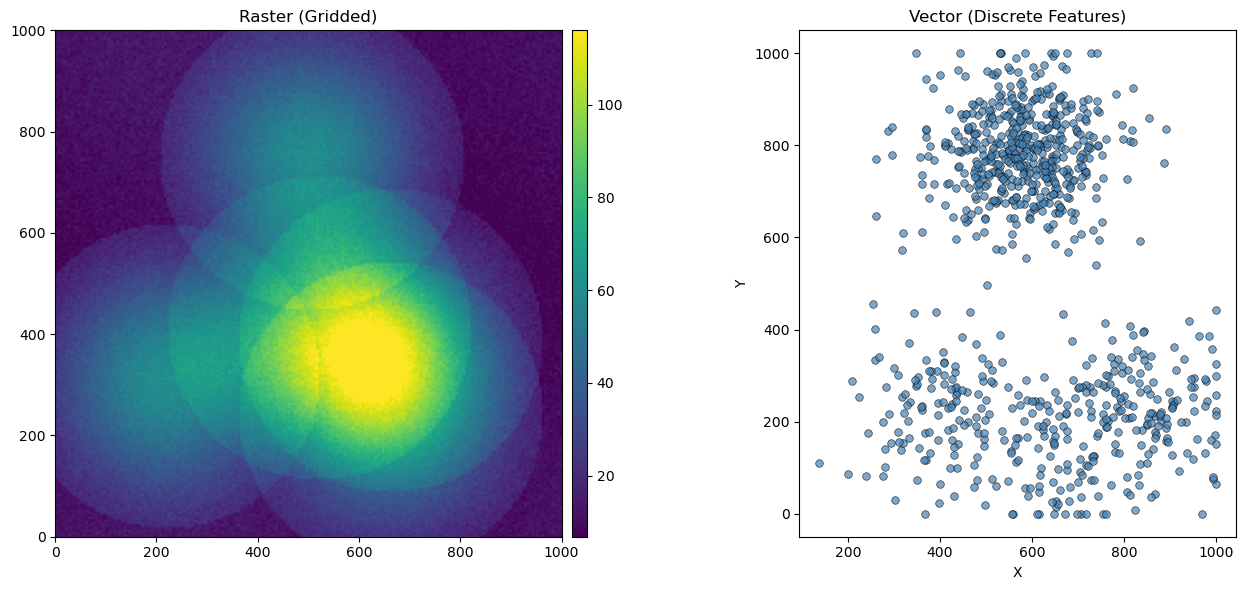

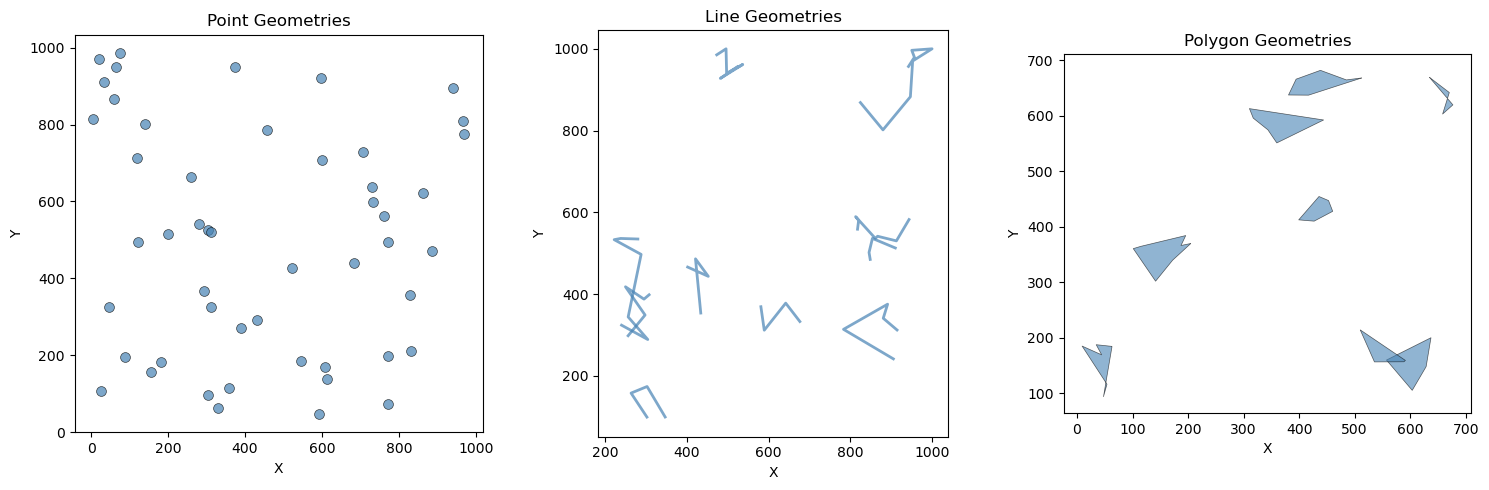

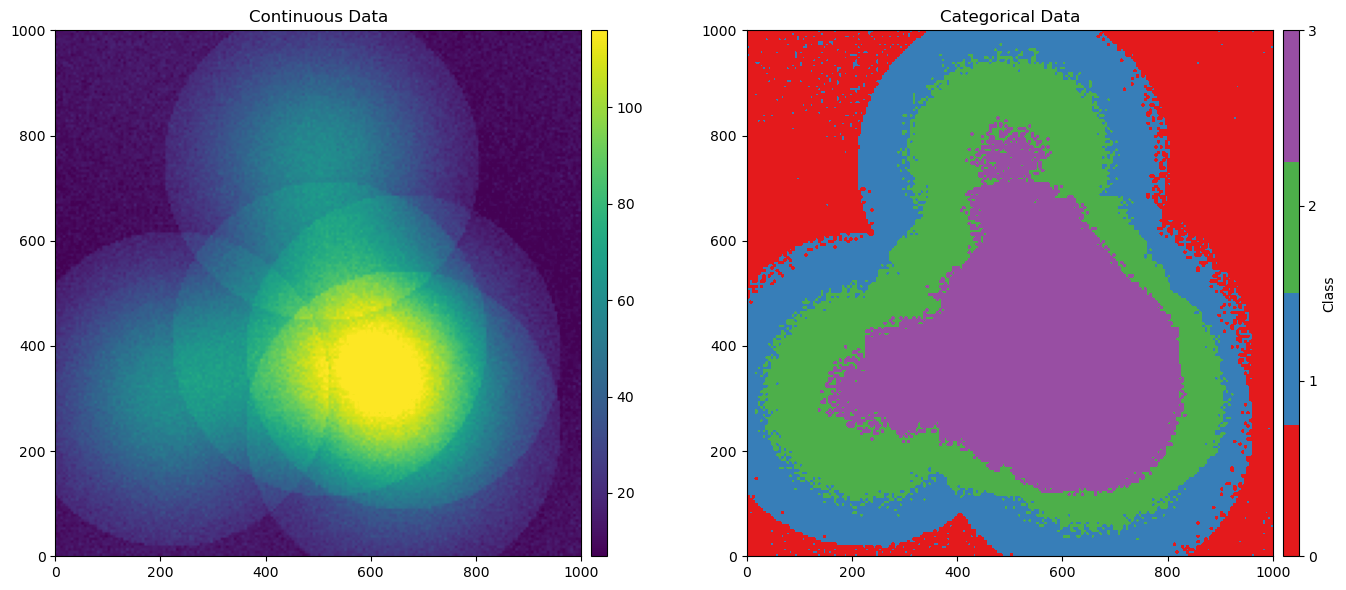

In [30]:
# Raster vs vector comparison
h.plot_raster_vs_vector(continuous_raster, geochem_gdf, extent=raster_extent)
plt.show()

# Point vs line vs polygon (synthetic)
if 'gdf_points' not in globals():
    gdf_points, gdf_lines, gdf_polygons = h.generate_synthetic_vector_geometries()

h.plot_geometry_types(gdf_points, gdf_lines, gdf_polygons)
plt.show()

# Continuous vs categorical rasters
h.plot_continuous_vs_categorical(continuous_raster, categorical_raster, extent=raster_extent)
plt.show()


## EDA, Transformations, and Scaling


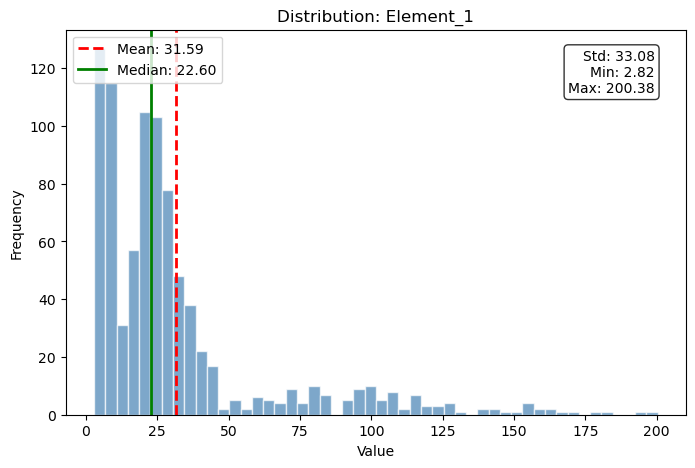

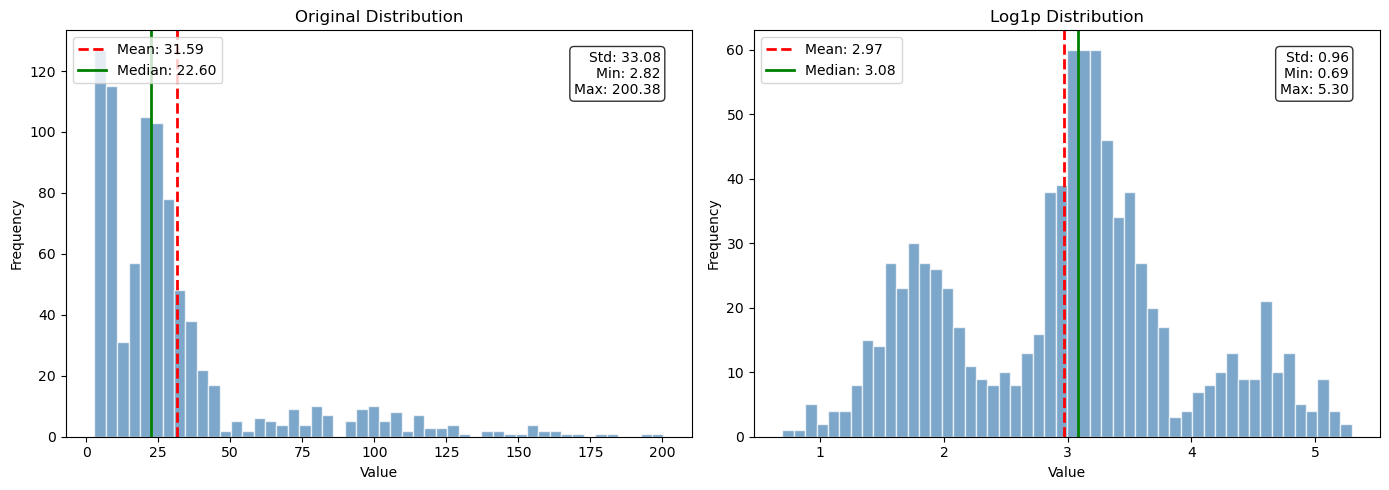

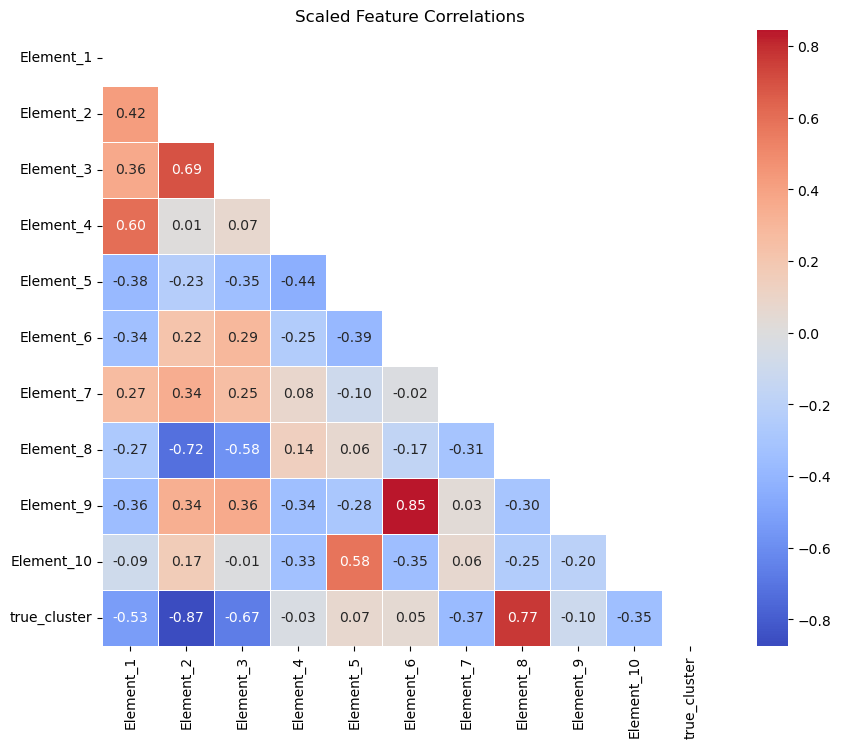

In [31]:
# Identify numeric feature columns
numeric_cols = geochem_gdf.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in ['X', 'Y']]
if not feature_cols:
    raise ValueError('No numeric feature columns found in geochem data.')

value_col = feature_cols[0]
values = geochem_gdf[value_col].values

# Distribution and log transform
h.plot_distribution(values, title=f'Distribution: {value_col}')
plt.show()

log_values = np.log1p(values - np.nanmin(values) + 1)
h.plot_transformation_comparison(values, log_values, transform_name='Log1p')
plt.show()

# Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(geochem_gdf[feature_cols])
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)

h.plot_correlation_matrix(scaled_df, title='Scaled Feature Correlations')
plt.show()


## Missing Data and Imputation


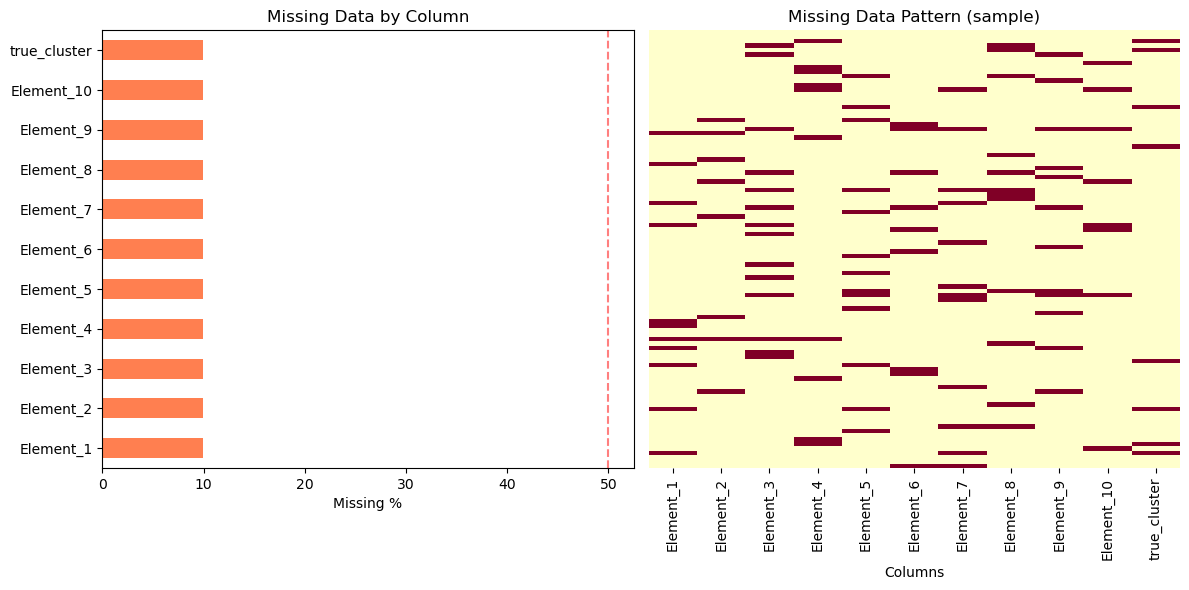

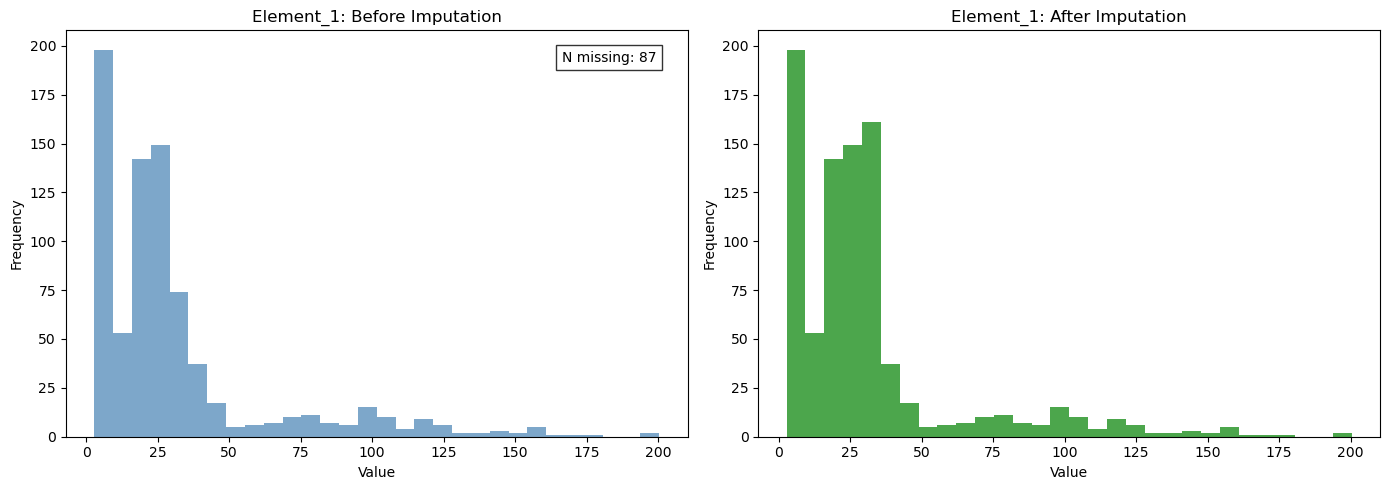

In [32]:
# Inject missing values for demonstration
geochem_missing = h.add_missing_data(geochem_gdf, missing_pct=0.1, columns=feature_cols)

h.plot_missing_data_pattern(geochem_missing[feature_cols])
plt.show()

# Mean imputation
imputer = SimpleImputer(strategy='mean')
imputed_values = imputer.fit_transform(geochem_missing[feature_cols])

h.plot_imputation_comparison(
    geochem_missing[value_col].values,
    imputed_values[:, feature_cols.index(value_col)],
    column_name=value_col
)
plt.show()


## Bias and Data Leakage (Spatial Autocorrelation)

Geologic data are often spatially autocorrelated, which inflates model performance when random train/test splits are used. Use spatially aware validation (e.g., block cross-validation or buffered splits) to reduce leakage.


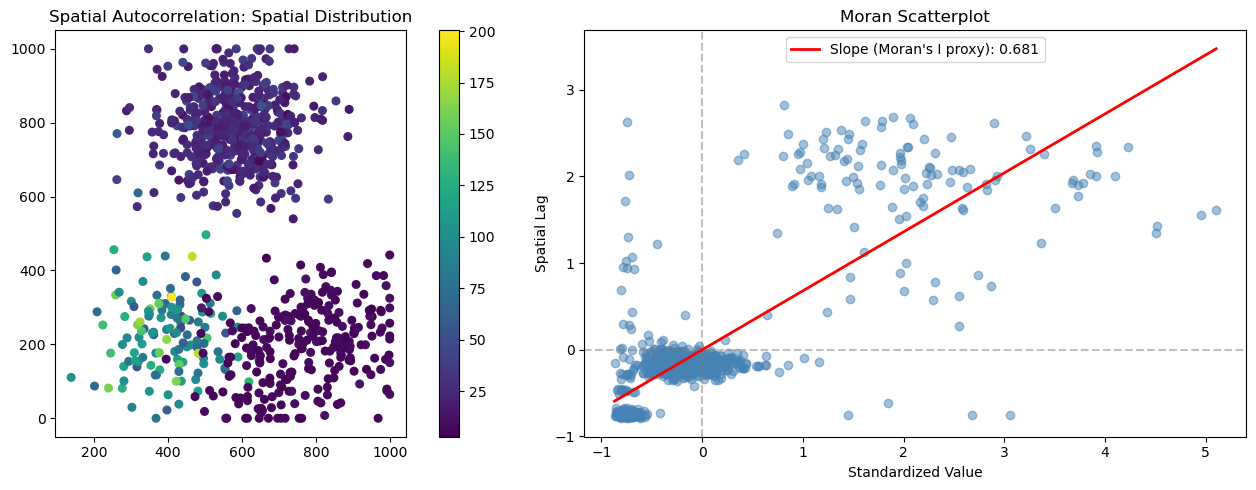

In [33]:
values = geochem_gdf[value_col].values
h.plot_spatial_autocorrelation(geochem_gdf, values, title='Spatial Autocorrelation')
plt.show()


## Analytical Methods


### Interpolation (IDW + Kriging)


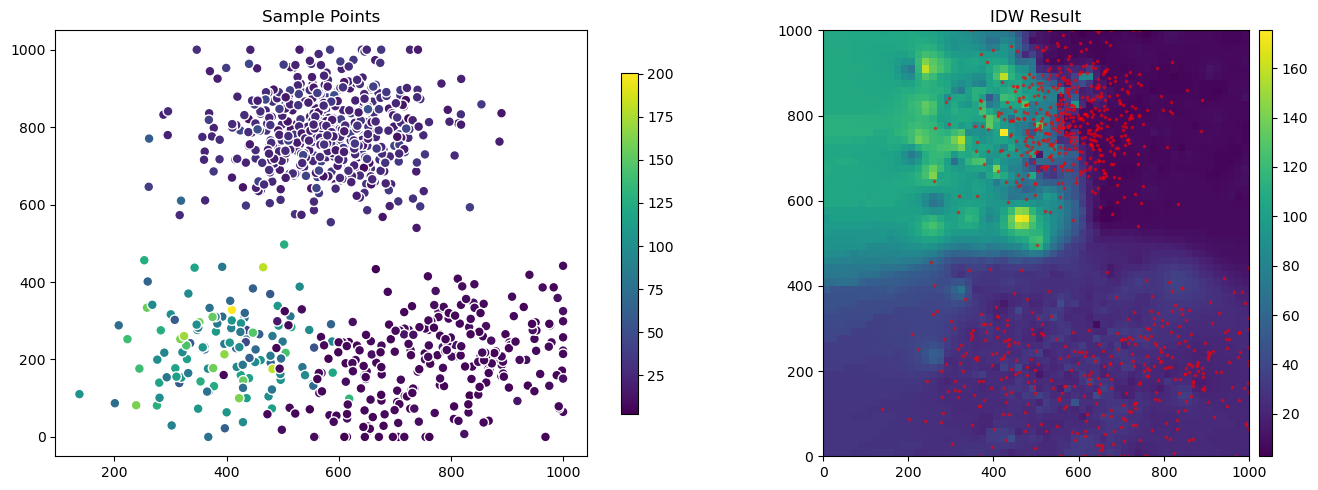

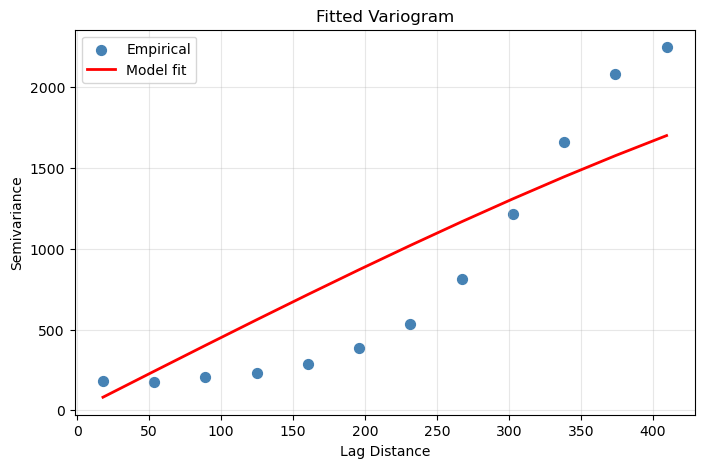

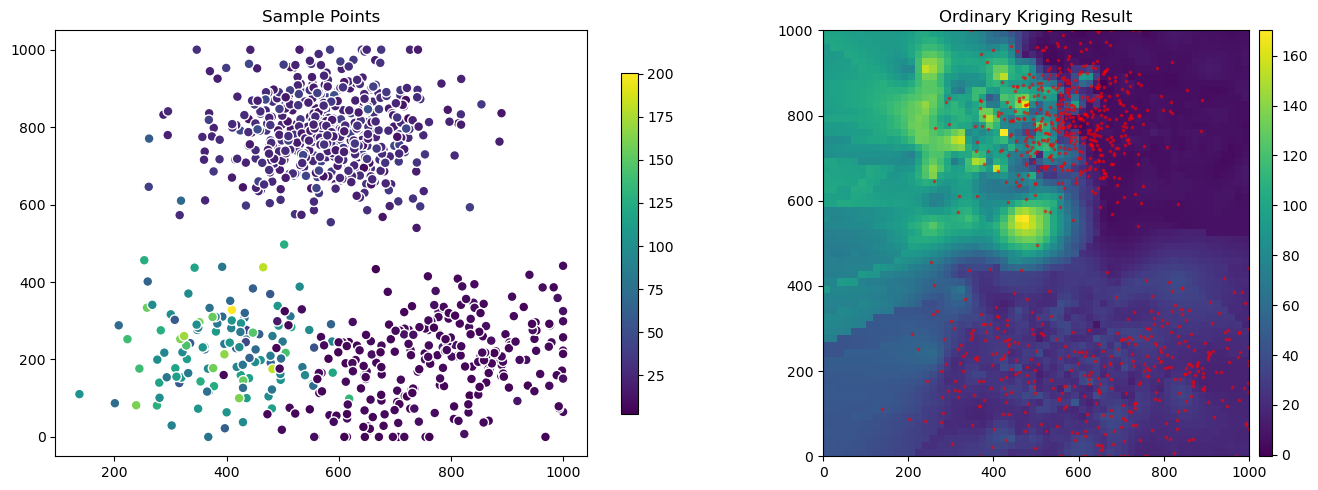

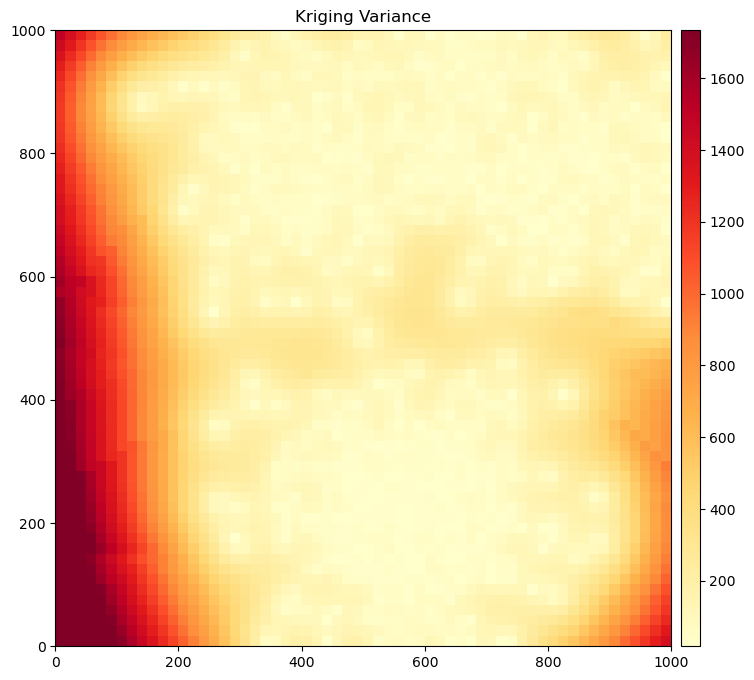

In [34]:
# Prepare sample points and grid
sample_coords = geochem_gdf[['X', 'Y']].values
sample_values = geochem_gdf[value_col].values

xmin, xmax, ymin, ymax = raster_extent
grid_resolution = 60
x_grid = np.linspace(xmin, xmax, grid_resolution)
y_grid = np.linspace(ymin, ymax, grid_resolution)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# IDW interpolation

def idw_interpolation(sample_coords, sample_values, grid_points, power=2, n_neighbors=12):
    tree = KDTree(sample_coords)
    distances, indices = tree.query(grid_points, k=n_neighbors)
    distances = np.maximum(distances, 1e-10)
    weights = 1 / (distances ** power)
    weights_sum = weights.sum(axis=1, keepdims=True)
    weights_normalized = weights / weights_sum
    interpolated = np.sum(weights_normalized * sample_values[indices], axis=1)
    return interpolated

idw_pred = idw_interpolation(sample_coords, sample_values, grid_points, power=2)
idw_grid = idw_pred.reshape(grid_resolution, grid_resolution)

h.plot_interpolation_results(sample_coords, sample_values, idw_grid, raster_extent, method_name='IDW')
plt.show()

# Empirical semivariogram

def compute_semivariogram(coords, values, n_lags=12, max_lag=None):
    dist_matrix = cdist(coords, coords)
    if max_lag is None:
        max_lag = np.percentile(dist_matrix, 50)

    lag_edges = np.linspace(0, max_lag, n_lags + 1)
    lag_centers = (lag_edges[:-1] + lag_edges[1:]) / 2

    semivariance = []
    for i in range(n_lags):
        mask = (dist_matrix > lag_edges[i]) & (dist_matrix <= lag_edges[i + 1])
        if mask.sum() > 0:
            ii, jj = np.where(mask)
            sq_diff = (values[ii] - values[jj]) ** 2
            semivariance.append(0.5 * np.mean(sq_diff))
        else:
            semivariance.append(np.nan)

    return lag_centers, np.array(semivariance)

lags, semivar = compute_semivariogram(sample_coords, sample_values)

# Spherical variogram model

def spherical_variogram(h, nugget, sill, range_param):
    h = np.asarray(h)
    result = np.zeros_like(h, dtype=float)

    mask = h > 0
    h_norm = h[mask] / range_param

    within_range = h_norm <= 1
    result_temp = np.zeros_like(h_norm)
    result_temp[within_range] = nugget + (sill - nugget) * (
        1.5 * h_norm[within_range] - 0.5 * h_norm[within_range] ** 3
    )
    result_temp[~within_range] = sill

    result[mask] = result_temp
    return result


def fit_variogram(lags, semivar):
    from scipy.optimize import curve_fit

    valid = ~np.isnan(semivar)
    lags_clean = lags[valid]
    semivar_clean = semivar[valid]

    if len(lags_clean) < 3:
        return 0, np.max(semivar_clean), np.max(lags_clean)

    nugget_init = semivar_clean[0] if semivar_clean[0] > 0 else 0
    sill_init = np.max(semivar_clean)
    range_init = np.max(lags_clean) / 2

    try:
        popt, _ = curve_fit(
            spherical_variogram,
            lags_clean,
            semivar_clean,
            p0=[nugget_init, sill_init, range_init],
            bounds=([0, 0, 1], [sill_init, sill_init * 2, np.max(lags_clean) * 2]),
            maxfev=5000,
        )
        return popt
    except Exception:
        return nugget_init, sill_init, range_init


def ordinary_kriging(sample_coords, sample_values, grid_points, nugget, sill, range_param, n_neighbors=12):
    tree = KDTree(sample_coords)
    predictions = np.zeros(len(grid_points))
    variances = np.zeros(len(grid_points))

    for i, point in enumerate(grid_points):
        distances, indices = tree.query(point, k=n_neighbors)

        if np.min(distances) < 1e-10:
            predictions[i] = sample_values[indices[0]]
            variances[i] = 0
            continue

        local_coords = sample_coords[indices]
        local_values = sample_values[indices]

        n = len(local_coords)
        K = np.zeros((n + 1, n + 1))

        for j in range(n):
            for k in range(n):
                dist = np.linalg.norm(local_coords[j] - local_coords[k])
                K[j, k] = sill - spherical_variogram(dist, nugget, sill, range_param)

        K[n, :n] = 1
        K[:n, n] = 1
        K[n, n] = 0

        k0 = np.zeros(n + 1)
        for j in range(n):
            dist = np.linalg.norm(local_coords[j] - point)
            k0[j] = sill - spherical_variogram(dist, nugget, sill, range_param)
        k0[n] = 1

        try:
            weights = np.linalg.solve(K, k0)
            predictions[i] = np.dot(weights[:n], local_values)
            variances[i] = sill - np.dot(weights[:n], k0[:n]) - weights[n]
        except Exception:
            w = 1 / (distances ** 2)
            predictions[i] = np.sum(w * local_values) / np.sum(w)
            variances[i] = np.var(local_values)

    return predictions, np.maximum(variances, 0)

nugget, sill, range_param = fit_variogram(lags, semivar)
model_fit = spherical_variogram(lags, nugget, sill, range_param)

h.plot_semivariogram(lags, semivar, model_fit=model_fit, title='Fitted Variogram')
plt.show()

kriging_pred, kriging_var = ordinary_kriging(
    sample_coords, sample_values, grid_points, nugget, sill, range_param, n_neighbors=12
)

kriging_grid = kriging_pred.reshape(grid_resolution, grid_resolution)
variance_grid = kriging_var.reshape(grid_resolution, grid_resolution)

h.plot_interpolation_results(sample_coords, sample_values, kriging_grid, raster_extent, method_name='Ordinary Kriging')
plt.show()

h.plot_raster(variance_grid, title='Kriging Variance', extent=raster_extent, cmap='YlOrRd')
plt.show()


### PCA


Original dimensions: 11
Explained variance ratio: [0.3564577  0.25440272 0.20364339 0.07373207 0.0294311  0.02702501
 0.01627888 0.01510378 0.0115653  0.00965836 0.00270169]
Cumulative variance: [0.3564577  0.61086042 0.81450381 0.88823587 0.91766697 0.94469199
 0.96097087 0.97607464 0.98763995 0.99729831 1.        ]


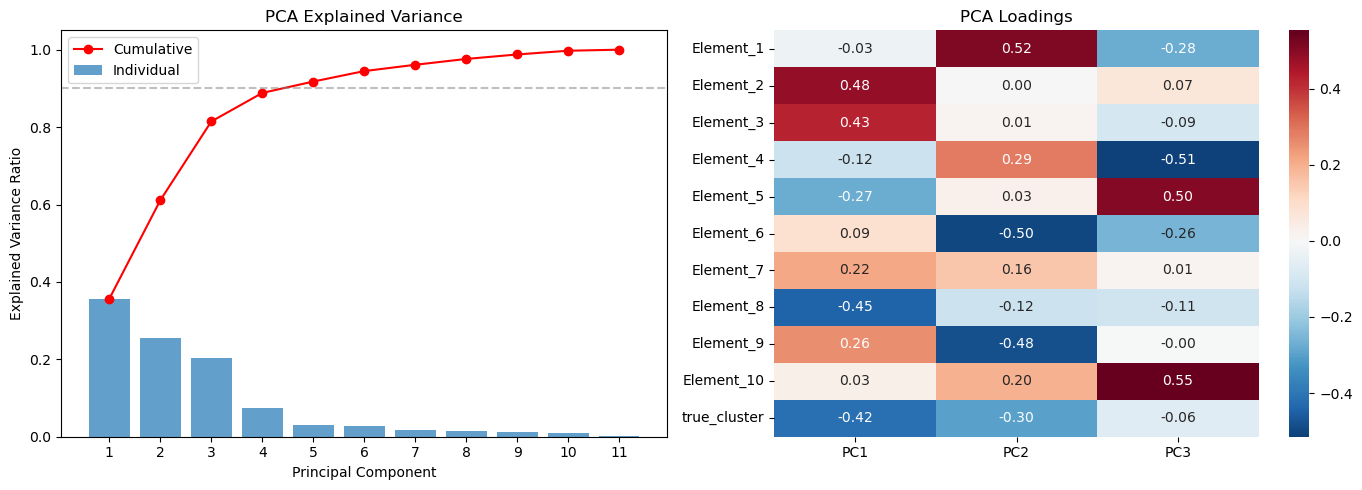


PCA INTERPRETATION:
-------------------
- PC1 often represents overall geochemical intensity
- Subsequent PCs capture orthogonal patterns (different processes)
- Loadings show which elements contribute to each PC
- Same-sign loadings: elements associated together
- Opposite-sign loadings: negatively correlated elements



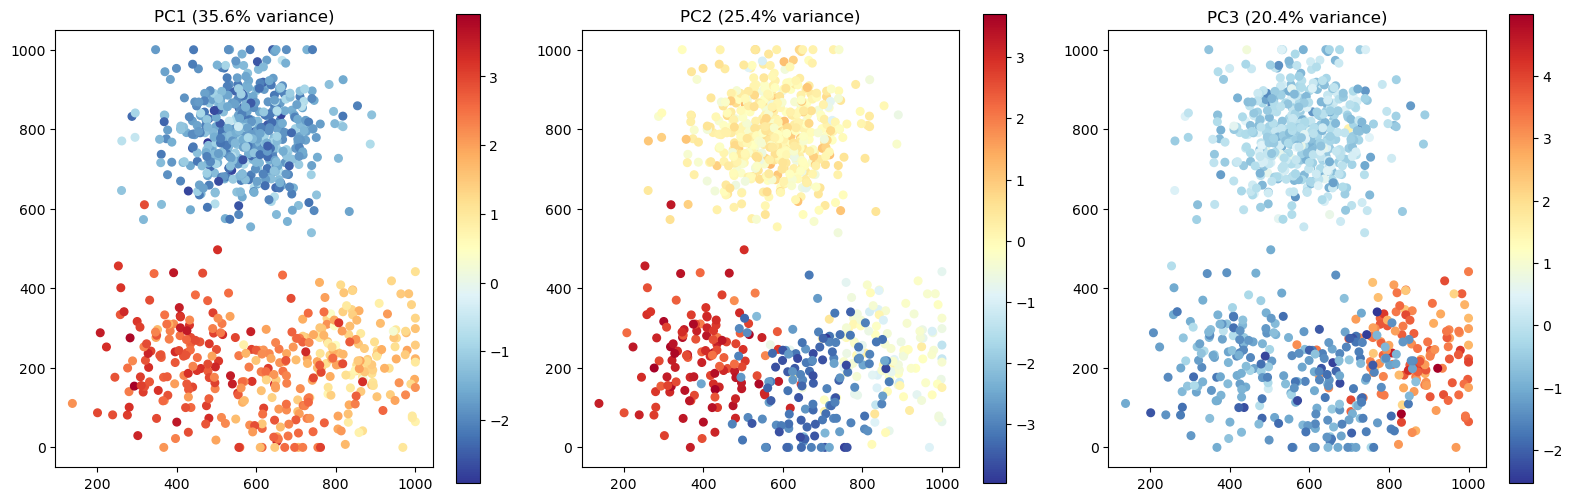

In [35]:
# Prepare data for PCA
X_geochem = geochem_gdf[feature_cols].values

# Log transform (common for geochemical data)
X_log = np.log(X_geochem + 1)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"Original dimensions: {X_geochem.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative variance: {np.cumsum(pca.explained_variance_ratio_)}")

# Visualize PCA results
fig, axes = h.plot_pca_results(pca, feature_cols, figsize=(14, 5))
plt.show()

print("""
PCA INTERPRETATION:
-------------------
- PC1 often represents overall geochemical intensity
- Subsequent PCs capture orthogonal patterns (different processes)
- Loadings show which elements contribute to each PC
- Same-sign loadings: elements associated together
- Opposite-sign loadings: negatively correlated elements
""")

# Spatial visualization of principal components
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, ax in enumerate(axes):
    gdf_temp = geochem_gdf.copy()
    gdf_temp[f'PC{i+1}'] = X_pca[:, i]
    gdf_temp.plot(column=f'PC{i+1}', ax=ax, legend=True, cmap='RdYlBu_r', markersize=30)
    ax.set_title(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.1f}% variance)')

plt.tight_layout()
plt.show()


### K-means (Geochemical Populations)


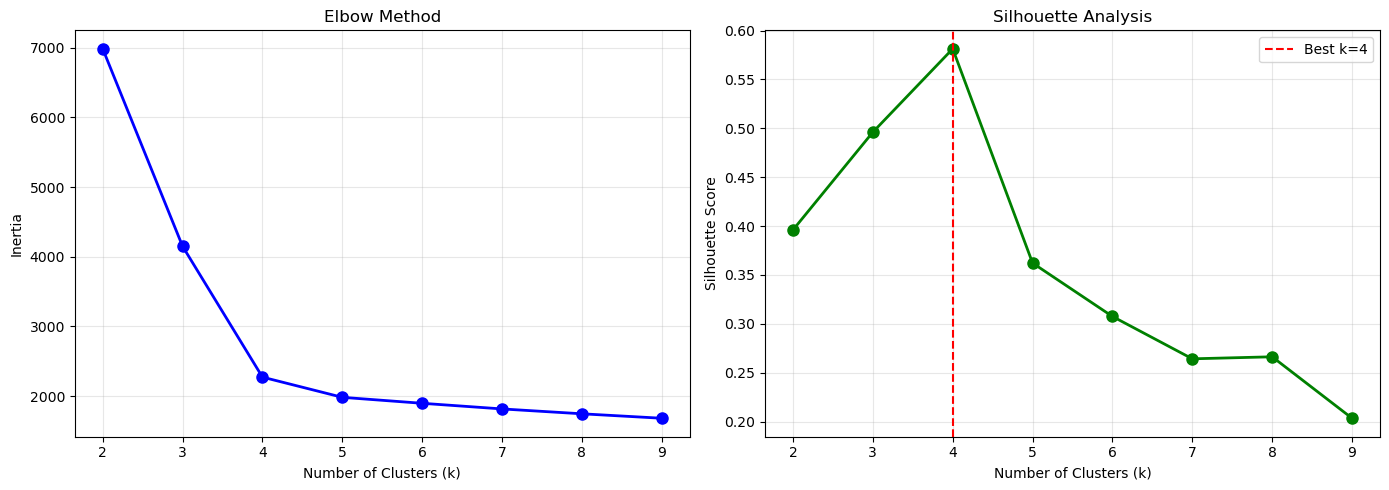

Optimal number of clusters (by silhouette): 4


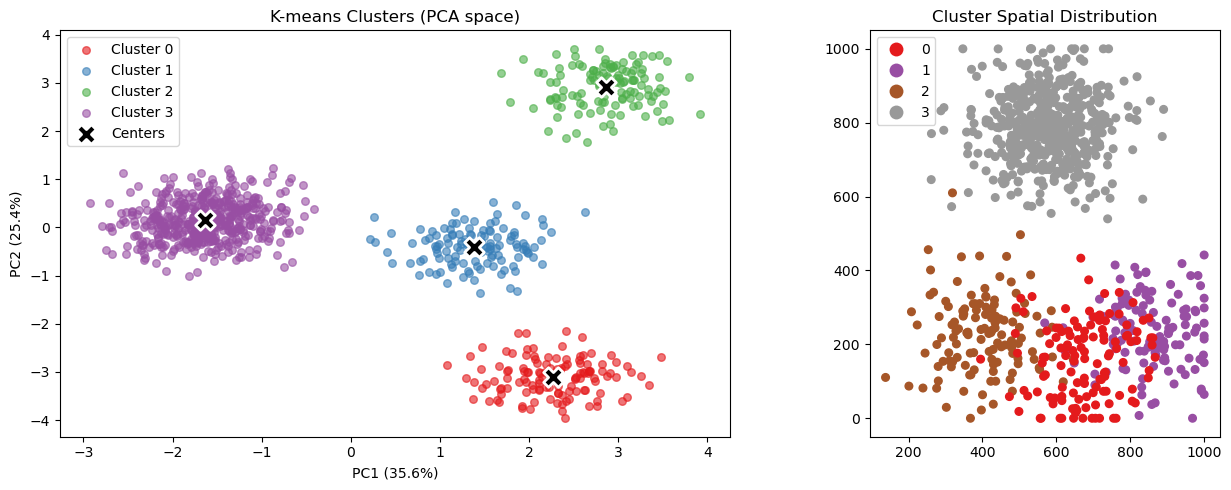

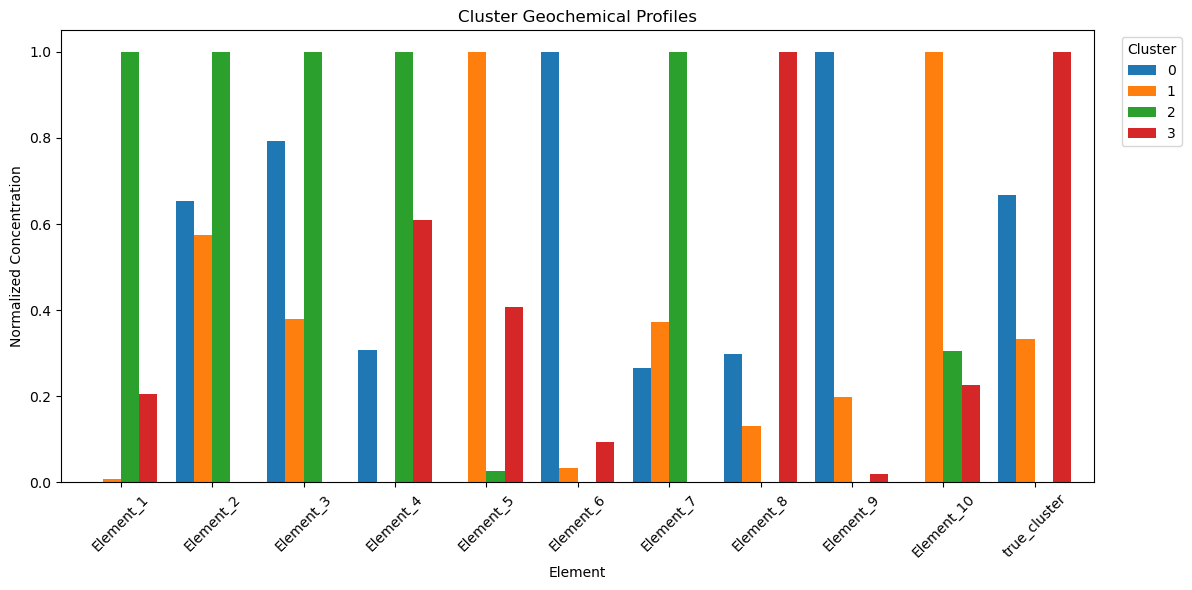


CLUSTER INTERPRETATION:
-----------------------
Each cluster represents a distinct geochemical population.
High values indicate enrichment in that cluster.
Use domain knowledge to interpret geological meaning:
- Lithological units
- Alteration assemblages
- Mineralization styles



In [36]:
# Find optimal number of clusters using elbow method and silhouette score
k_range = range(2, 10)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, axes = h.plot_elbow_silhouette(list(k_range), inertias, silhouettes, figsize=(14, 5))
plt.show()

# Find optimal k
optimal_k = list(k_range)[np.argmax(silhouettes)]
print(f"Optimal number of clusters (by silhouette): {optimal_k}")

# Apply K-means with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Visualize in PCA space
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PCA biplot with clusters
h.plot_clustering_results(
    X_pca,
    cluster_labels,
    centers=pca.transform(kmeans_final.cluster_centers_),
    title='K-means Clusters (PCA space)',
    ax=axes[0],
    feature_x=0,
    feature_y=1,
)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')

# Spatial distribution of clusters
gdf_clustered = geochem_gdf.copy()
gdf_clustered['cluster'] = cluster_labels
gdf_clustered.plot(column='cluster', ax=axes[1], legend=True,
                   categorical=True, cmap='Set1', markersize=30)
axes[1].set_title('Cluster Spatial Distribution')

plt.tight_layout()
plt.show()

# Cluster profiles (mean element concentrations per cluster)
gdf_clustered['cluster'] = cluster_labels

cluster_profiles = gdf_clustered.groupby('cluster')[feature_cols].mean()

# Normalize for comparison
cluster_profiles_norm = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

fig, ax = plt.subplots(figsize=(12, 6))
cluster_profiles_norm.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Element')
ax.set_ylabel('Normalized Concentration')
ax.set_title('Cluster Geochemical Profiles')
ax.legend(title='Cluster', bbox_to_anchor=(1.02, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("""
CLUSTER INTERPRETATION:
-----------------------
Each cluster represents a distinct geochemical population.
High values indicate enrichment in that cluster.
Use domain knowledge to interpret geological meaning:
- Lithological units
- Alteration assemblages
- Mineralization styles
""")


### Multivariate Anomaly Detection (Isolation Forest)

See full reference implementation in `anomaly_detection/`.


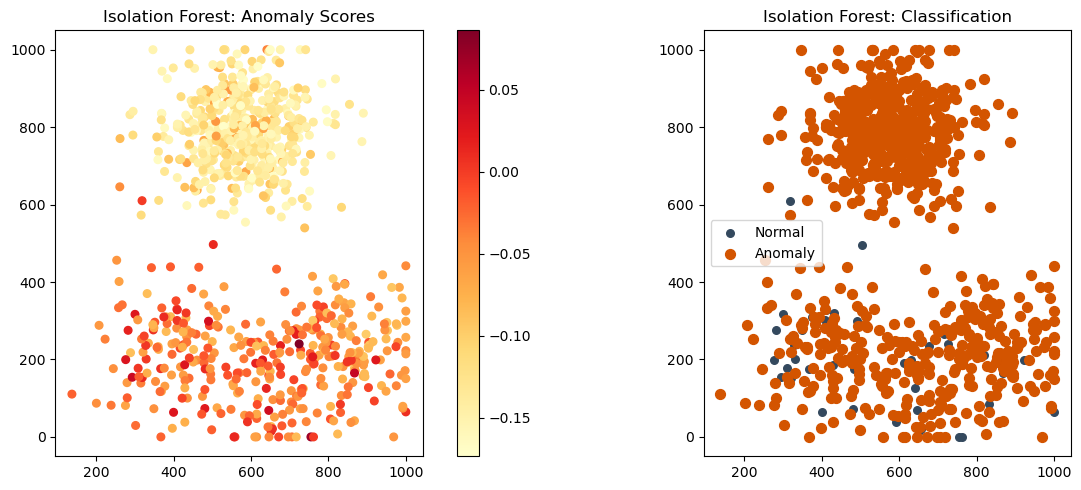

In [37]:
iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
iso_labels = iso.fit_predict(scaled_features)
scores = -iso.decision_function(scaled_features)

h.plot_anomaly_scores(geochem_gdf, scores, binary_labels=iso_labels, title='Isolation Forest')
plt.show()


### Spectral Halo Classification

See full reference implementation in `MinersWork/spectral_unsupervised/spectral_unsupervised_class.ipynb`.


Use indices like clay/Al-OH, iron oxide (ferric), ferrous iron, silica, gossan, and laterite. Sentinel-2 does not provide a direct carbonate index, so these act as proxies.


Loaded 6 spectral indices


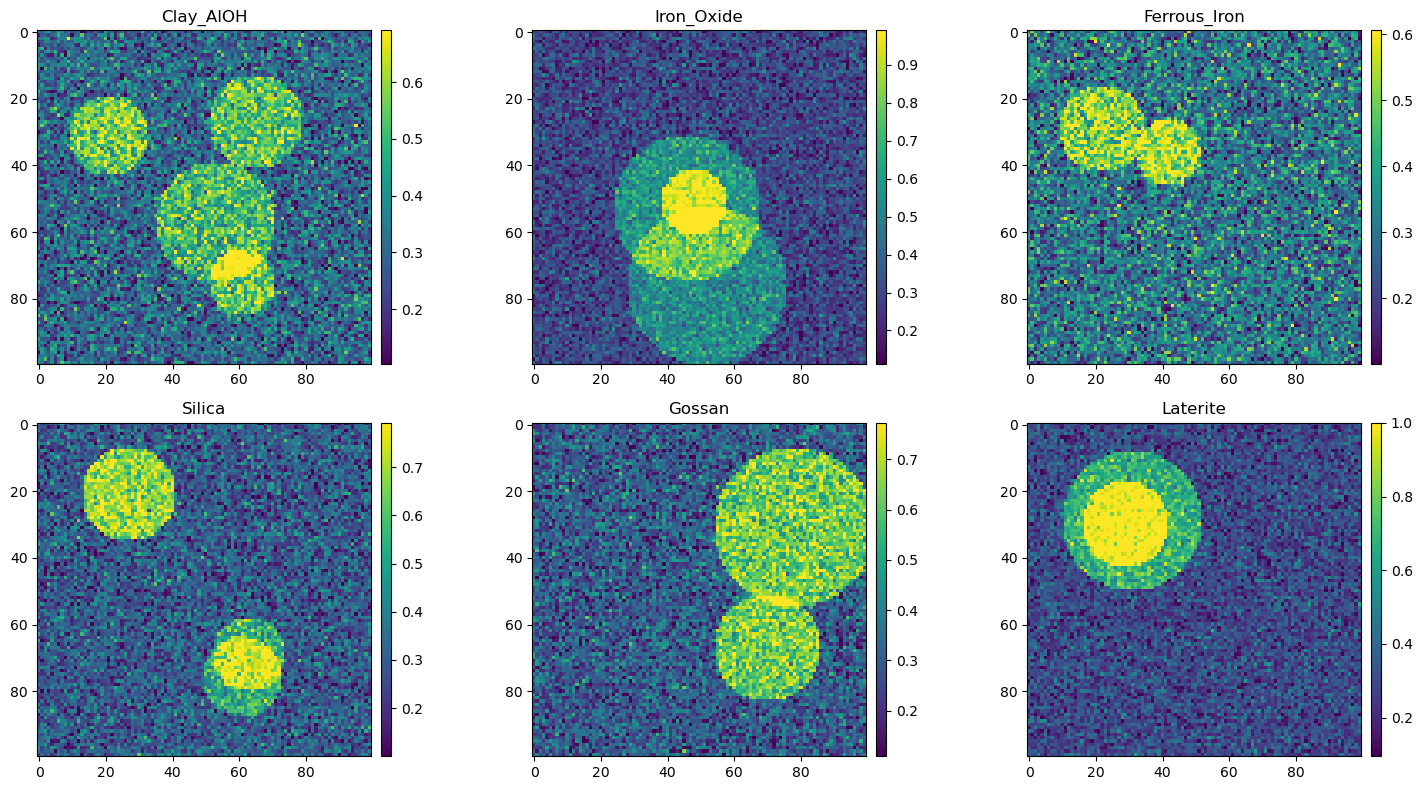

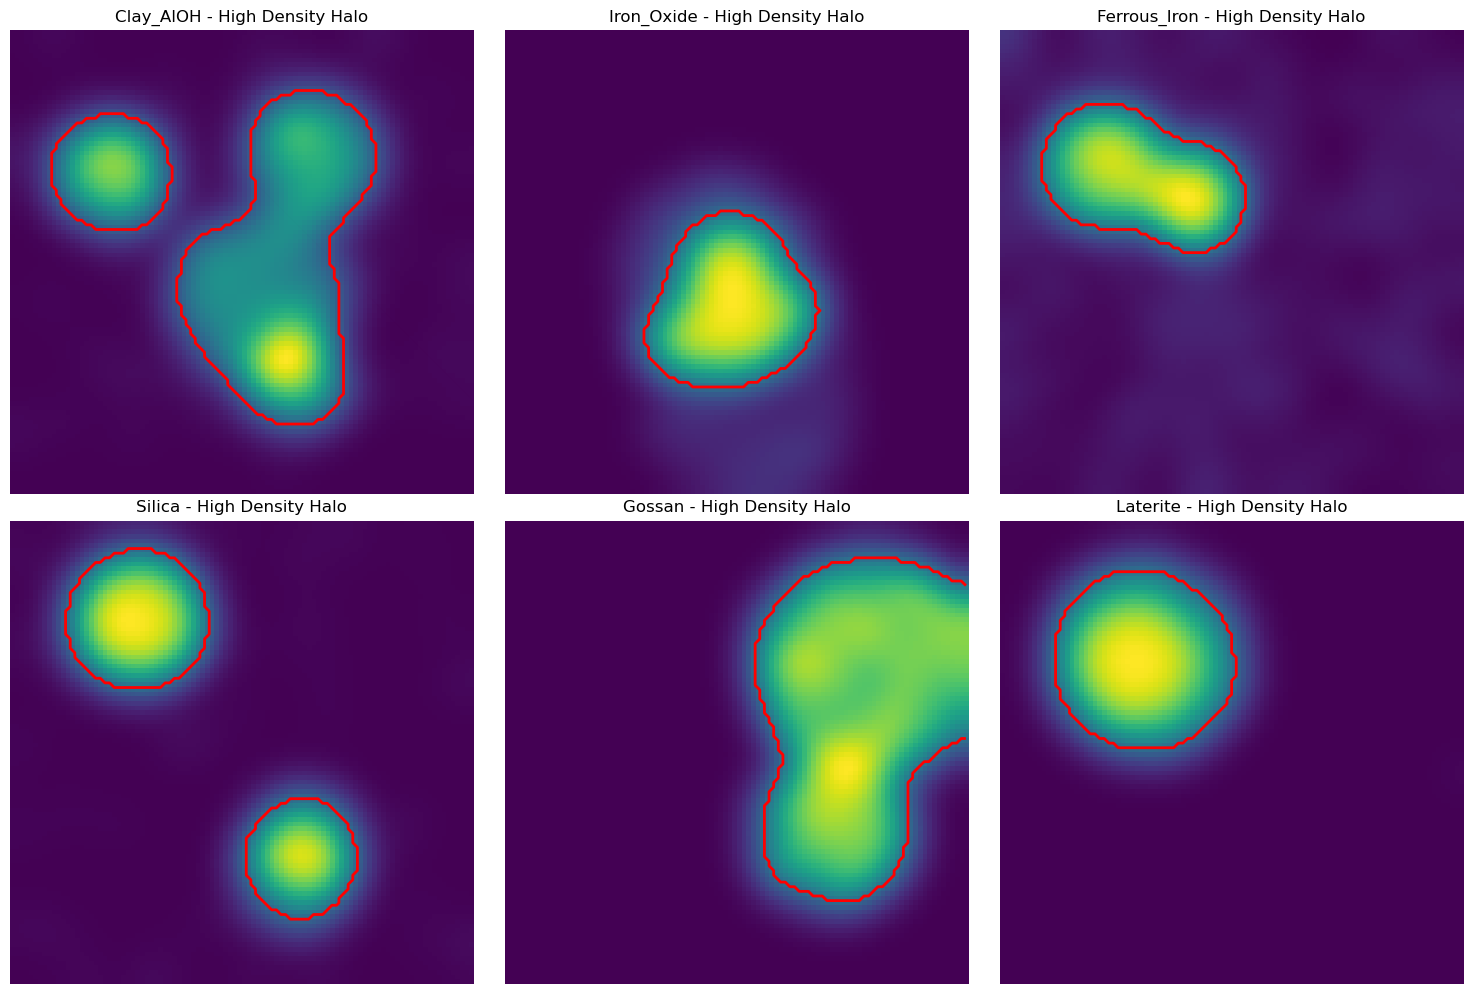

Alteration type classes:
0: Background
1: Advanced Argillic (466 pixels, 4.7%)
2: Phyllic (1045 pixels, 10.4%)
3: Argillic (180 pixels, 1.8%)
4: Propylitic (1010 pixels, 10.1%)
5: Gossan (1862 pixels, 18.6%)
6: Laterite (491 pixels, 4.9%)


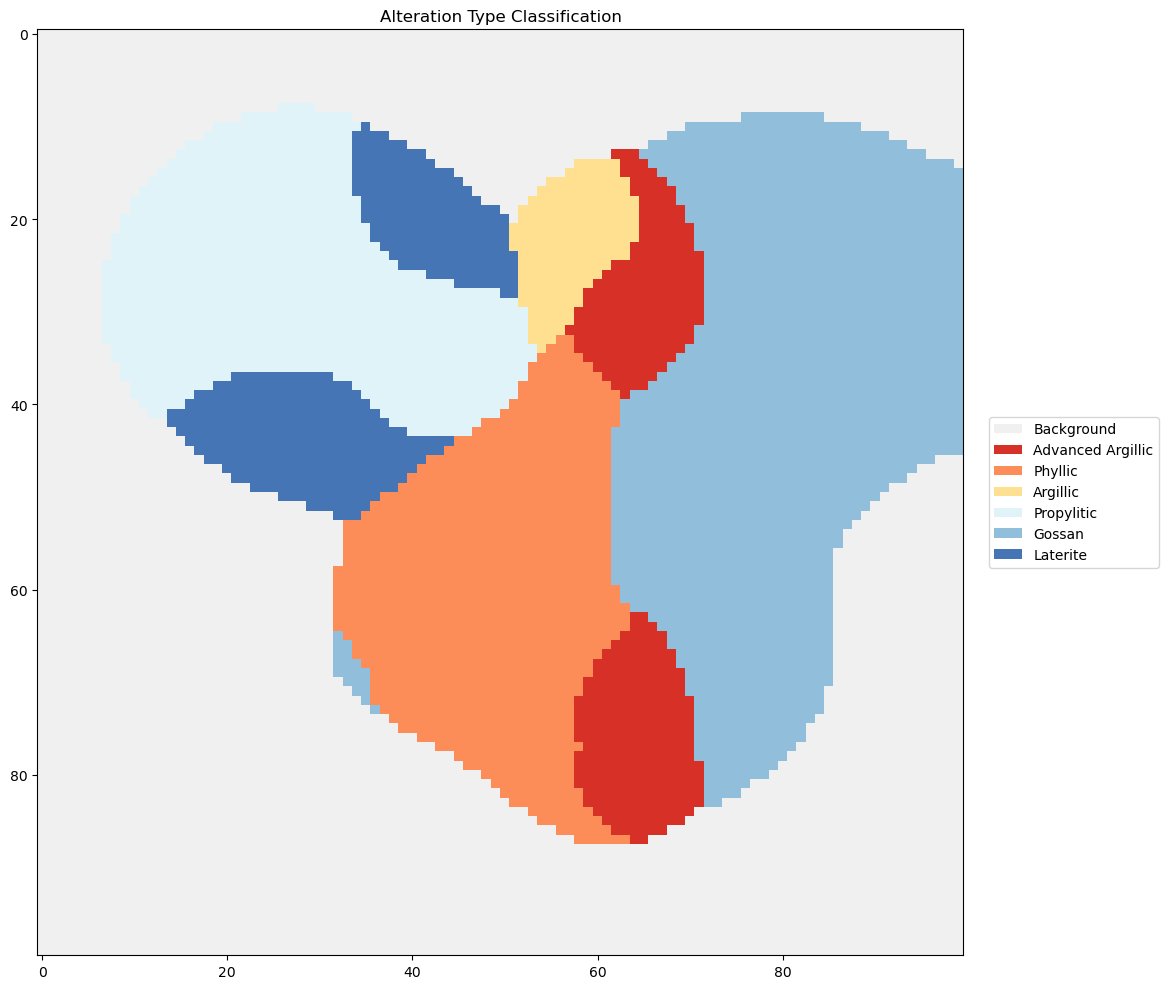


SPECTRAL HALO CLASSIFICATION:
-----------------------------
This unsupervised approach identifies alteration types based on:
1. Spectral index values (proxy for mineralogy)
2. Spatial density patterns (KDE)
3. Weighted combinations based on expected assemblages

Validation should include:
- Field verification of predicted alteration types
- Comparison with known mineralization
- Cross-validation with other datasets (geochemistry, geophysics)



In [38]:
# Generate or load spectral indices for demonstration
# In practice, these would be computed from multispectral imagery

np.random.seed(42)

spectral_indices = {}

if DATA_CONFIG['spectral_indices_dir']:
    dir_path = Path(DATA_CONFIG['spectral_indices_dir'])
    spectral_extent = None
    for tif_path in dir_path.glob('*.tif'):
        data, extent, _ = load_raster(tif_path)
        spectral_indices[tif_path.stem] = data
        if spectral_extent is None:
            spectral_extent = extent
    if spectral_extent is None:
        spectral_extent = raster_extent

if not spectral_indices:
    raster_shape = (100, 100)

    def generate_spectral_index(shape, n_anomalies=3, background=0.3, anomaly_strength=0.4):
        data = np.random.normal(background, 0.1, shape)

        for _ in range(n_anomalies):
            cx, cy = np.random.randint(20, 80, 2)
            radius = np.random.randint(10, 25)
            y, x = np.ogrid[:shape[0], :shape[1]]
            mask = ((x - cx) ** 2 + (y - cy) ** 2) < radius ** 2
            data[mask] += np.random.uniform(anomaly_strength * 0.5, anomaly_strength)

        return np.clip(data, 0, 1)

    spectral_indices = {
        'Clay_AlOH': generate_spectral_index(raster_shape, n_anomalies=4),
        'Iron_Oxide': generate_spectral_index(raster_shape, n_anomalies=3),
        'Ferrous_Iron': generate_spectral_index(raster_shape, n_anomalies=2),
        'Silica': generate_spectral_index(raster_shape, n_anomalies=3),
        'Gossan': generate_spectral_index(raster_shape, n_anomalies=2),
        'Laterite': generate_spectral_index(raster_shape, n_anomalies=2),
    }

raster_shape = next(iter(spectral_indices.values())).shape
print(f"Loaded {len(spectral_indices)} spectral indices")

# Visualize spectral indices
n_indices = len(spectral_indices)
cols = 3
rows = int(np.ceil(n_indices / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = np.atleast_1d(axes).ravel()

for ax, (name, data) in zip(axes, spectral_indices.items()):
    h.plot_raster(data, ax=ax, title=name, cmap='viridis', robust_stretch=True)

for ax in axes[len(spectral_indices):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


def compute_halo_detection(index_data, percentile_threshold=90, sigma=5):
    """Detect high-density halos using KDE and K-means."""
    # Robust z-scoring
    p1, p99 = np.percentile(index_data, [1, 99])
    clipped = np.clip(index_data, p1, p99)
    median_val = np.median(clipped)
    iqr = np.percentile(clipped, 75) - np.percentile(clipped, 25)
    z_scored = (clipped - median_val) / (iqr + 1e-10)

    # Presence mask (top percentile)
    threshold = np.percentile(z_scored, percentile_threshold)
    presence_mask = z_scored >= threshold

    # KDE via Gaussian filter
    kde_surface = gaussian_filter(presence_mask.astype(float), sigma=sigma)

    # K-means to split high/low density
    kde_flat = kde_surface.flatten().reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(kde_flat).reshape(index_data.shape)

    # Identify high-density cluster
    cluster_means = [kde_surface[cluster_labels == i].mean() for i in range(2)]
    high_density_label = np.argmax(cluster_means)
    high_density_mask = cluster_labels == high_density_label

    return kde_surface, high_density_mask


# Apply halo detection for each index
kde_surfaces = {}
halo_masks = {}
for name, data in spectral_indices.items():
    kde, mask = compute_halo_detection(data, percentile_threshold=90, sigma=5)
    kde_surfaces[name] = kde
    halo_masks[name] = mask
# Visualize halo detection results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (name, kde) in zip(axes, kde_surfaces.items()):
    ax.imshow(kde, cmap='viridis', origin='upper')
    ax.contour(halo_masks[name], levels=[0.5], colors='red', linewidths=2)
    ax.set_title(f'{name} - High Density Halo')
    ax.axis('off')

for ax in axes[len(kde_surfaces):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# Alteration type classification using weighted combination
# Weights based on typical alteration assemblages
alteration_weights = {
    'Advanced Argillic': {'Clay_AlOH': 0.4, 'Silica': 0.3, 'Iron_Oxide': 0.2, 'Gossan': 0.1},
    'Phyllic': {'Clay_AlOH': 0.5, 'Iron_Oxide': 0.3, 'Silica': 0.2},
    'Argillic': {'Clay_AlOH': 0.5, 'Silica': 0.2, 'Laterite': 0.2, 'Iron_Oxide': 0.1},
    'Propylitic': {'Ferrous_Iron': 0.4, 'Clay_AlOH': 0.2, 'Laterite': 0.2, 'Silica': 0.2},
    'Gossan': {'Iron_Oxide': 0.4, 'Gossan': 0.4, 'Silica': 0.2},
    'Laterite': {'Laterite': 0.6, 'Iron_Oxide': 0.2, 'Clay_AlOH': 0.2},
}


def normalize_kde(kde, percentile_low=2, percentile_high=98):
    """Robust normalization of KDE surface."""
    p_low, p_high = np.percentile(kde, [percentile_low, percentile_high])
    normalized = (kde - p_low) / (p_high - p_low + 1e-10)
    return np.clip(normalized, 0, 1)

# Normalize all KDE surfaces
kde_normalized = {name: normalize_kde(kde) for name, kde in kde_surfaces.items()}

# Compute weighted scores for each alteration type
alteration_scores = {}
for alt_type, weights in alteration_weights.items():
    score = np.zeros(raster_shape)
    for index_name, weight in weights.items():
        if index_name in kde_normalized:
            score += weight * kde_normalized[index_name]
    alteration_scores[alt_type] = score

# Classify based on highest score
all_scores = np.stack([alteration_scores[k] for k in alteration_weights.keys()], axis=-1)
class_map = np.argmax(all_scores, axis=-1) + 1

# Mask low-confidence areas
max_scores = np.max(all_scores, axis=-1)
confidence_threshold = 0.2
class_map[max_scores < confidence_threshold] = 0

print("Alteration type classes:")
print("0: Background")
for i, name in enumerate(alteration_weights.keys(), 1):
    count = (class_map == i).sum()
    print(f"{i}: {name} ({count} pixels, {count / class_map.size * 100:.1f}%)")

# Visualize alteration classification
class_names = ['Background'] + list(alteration_weights.keys())
fig, ax = h.plot_alteration_map(class_map, class_names=class_names, figsize=(12, 10))
plt.show()

print("""
SPECTRAL HALO CLASSIFICATION:
-----------------------------
This unsupervised approach identifies alteration types based on:
1. Spectral index values (proxy for mineralogy)
2. Spatial density patterns (KDE)
3. Weighted combinations based on expected assemblages

Validation should include:
- Field verification of predicted alteration types
- Comparison with known mineralization
- Cross-validation with other datasets (geochemistry, geophysics)
""")


### Supervised ML Prospectivity Mapping

See full reference implementation in `supervised_ML/`.


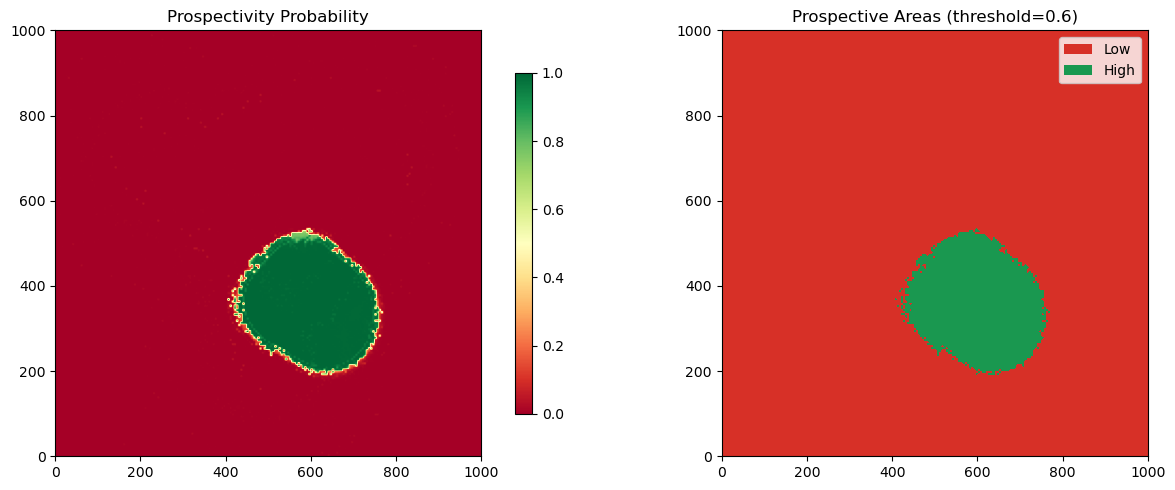

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       548
           1       1.00      1.00      1.00        52

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [39]:
# Synthetic raster stack (or load from user paths)
if DATA_CONFIG['prospectivity_feature_rasters']:
    feature_stack = []
    for path in DATA_CONFIG['prospectivity_feature_rasters']:
        data, extent, _ = load_raster(path)
        feature_stack.append(data)
    prospect_extent = extent
    feature_stack = np.stack(feature_stack, axis=-1)
else:
    r1 = continuous_raster
    r2 = gaussian_filter(continuous_raster, sigma=4)
    r3 = np.flipud(continuous_raster)
    feature_stack = np.stack([r1, r2, r3], axis=-1)
    prospect_extent = raster_extent

rows, cols, n_features = feature_stack.shape

# Training data
if DATA_CONFIG['prospectivity_training_points_path']:
    train_gdf = load_vector(DATA_CONFIG['prospectivity_training_points_path'])
    label_candidates = [c for c in train_gdf.columns if c.lower() in ['label', 'target', 'prospectivity']]
    if not label_candidates:
        raise ValueError('Training points file must include a label column like label/target/prospectivity.')
    label_col = label_candidates[0]

    train_gdf = ensure_xy(train_gdf)
    xmin, xmax, ymin, ymax = prospect_extent

    col_idx = ((train_gdf['X'] - xmin) / (xmax - xmin) * (cols - 1)).astype(int)
    row_idx = ((ymax - train_gdf['Y']) / (ymax - ymin) * (rows - 1)).astype(int)
    valid = (col_idx >= 0) & (col_idx < cols) & (row_idx >= 0) & (row_idx < rows)

    X = feature_stack[row_idx[valid], col_idx[valid], :]
    y = train_gdf.loc[valid, label_col].values
else:
    # Synthetic labels from a high-value anomaly
    label_raster = (feature_stack[..., 0] > np.nanpercentile(feature_stack[..., 0], 92)).astype(int)

    n_samples = 2000
    rng = np.random.default_rng(42)
    row_idx = rng.integers(0, rows, n_samples)
    col_idx = rng.integers(0, cols, n_samples)

    X = feature_stack[row_idx, col_idx, :]
    y = label_raster[row_idx, col_idx]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict prospectivity across the grid
flat_features = feature_stack.reshape(-1, n_features)
prob = rf.predict_proba(flat_features)[:, 1].reshape(rows, cols)

h.plot_prospectivity_map(prob, extent=prospect_extent, threshold=0.6)
plt.show()

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test)))
